# Multi-Resolution Tutorial

This tutorial shows how to model sources frome images observed with different telescopes. We will use a multiband observation with the Hyper-Sprime Cam (HSC) and a single high-resolution image from the Hubble Space Telescope (HST).

In [1]:
# Import Packages and setup
import numpy as np
import scarlet
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

## Load Data

We first load the HSC and HST images, channel names, and PSFs. For the images, we need to swap the byte order if necessary because a bug in astropy does not respect the local endianness... We also don't have precomputed weight/variance maps, so we will need to compute them afterwards.

In [2]:
# Load the HSC image data
obs_hdu = fits.open('../../data/test_resampling/Cut_HSC1.fits')
data_hsc = obs_hdu[0].data.byteswap().newbyteorder()
wcs_hsc = WCS(obs_hdu[0].header)
channels_hsc = ['g','r','i','z','y']

# Load the HSC PSF data
psf_hsc = fits.open('../../data/test_resampling/PSF_HSC.fits')[0].data
Np1, Np2 = psf_hsc[0].shape
psf_hsc = scarlet.ImagePSF(psf_hsc)

# Load the HST image data
hst_hdu = fits.open('../../data/test_resampling/Cut_HST1.fits')
data_hst = hst_hdu[0].data
wcs_hst = WCS(hst_hdu[0].header)
channels_hst = ['F814W']

# Load the HST PSF data
psf_hst = fits.open('../../data/test_resampling/PSF_HST.fits')[0].data
psf_hst = psf_hst[None,:,:]
psf_hst = scarlet.ImagePSF(psf_hst)

# Scale the HST data
n1,n2 = np.shape(data_hst)
data_hst = data_hst.reshape(1, n1, n2).byteswap().newbyteorder()
data_hst *= data_hsc.max() / data_hst.max()

r, N1, N2 = data_hsc.shape

## Create Frame and Observations

Unlike the single resolution examples, we now have two different instruments with different pixel resolutions, so we need two different observations. Since the HST image is at a much higher resolution, we define our model `Frame` to use the HST PSF and the HST resolution. Because there is no resampling between the model frame and the HST observation, we can use the default `Observation` class for the HST data. The HSC images have lower resolution, so we need to resample the models to this frame, and that's done by `LowResObservation`.

Users can specify `Frame`, `Observation` and `LowResObservation` instances by hand and match them as is usually done in single observation fitting. Alternatively, the user can provide a list of observation (no matter what the resolution of each observation is), from which the `from_observations` method will decide how large the model frame has to be and which observation(s) should be a `LowResObservation`.

In [3]:
# define two observation packages and match to frame
obs_hst = scarlet.Observation(data_hst, 
                              wcs=wcs_hst, 
                              psf=psf_hst, 
                              channels=channels_hst, 
                              weights=None)

obs_hsc = scarlet.Observation(data_hsc, 
                              wcs=wcs_hsc, 
                              psf=psf_hsc, 
                              channels=channels_hsc, 
                              weights=None)

observations = [obs_hsc, obs_hst]
model_psf = scarlet.GaussianPSF(sigma=0.6)
model_frame = scarlet.Frame.from_observations(observations, coverage='intersection', model_psf=model_psf)
obs_hsc, obs_hst = observations

Next we have to create a source catalog for the images. We'll use `sep` for that, but any other detection method will do. Since HST is higher resolution and less affected by blending, we use it for detection but we also run detection on the HSC image to calculate the background RMS:

In [4]:
import sep
        
def makeCatalog(obs_lr, obs_hr, lvl = 3, wave = True):
    # Create a catalog of detected source by running SEP on the wavelet transform 
    # of the sum of the high resolution images and the low resolution images interpolated to the high resolution grid
    #Interpolate LR to HR
    interp = scarlet.interpolation.interpolate_observation(obs_lr, obs_hr)
    # Normalisation 
    interp = interp/np.sum(interp, axis = (1,2))[:,None, None]
    hr_images = obs_hr.data/np.sum(obs_hr.data, axis = (1,2))[:,None, None]
    # Summation to create a detection image
    detect_image = np.sum(interp, axis = 0) + np.sum(hr_images, axis = 0)
    # Rescaling to HR image flux
    detect_image *= np.sum(obs_hr.data)
    # Wavelet transform
    wave_detect = scarlet.Starlet(detect_image, direct = False).coefficients[0]
    
    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 3, err=bkg.globalrms)
    bg_rms = []
    for img in [obs_lr.data, obs_hr.data]:
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
        
    return catalog, bg_rms, detect_image

# Making catalog. 
# With the wavelet option on, only the first 3 wavelet levels are used for detection. Set to 1 for better detection
wave = 1
lvl = 3
catalog_hst, (bg_hsc, bg_hst), detect = makeCatalog(obs_hsc, obs_hst, lvl, wave)

# we can now set the empirical noise rms for both observations
obs_hsc.weights = np.ones(obs_hsc.shape) / (bg_hsc**2)[:, None, None]
obs_hst.weights = np.ones(obs_hst.shape) / (bg_hst**2)[:, None, None]

Finally we can visualize the detections for the multi-band HSC and single-band HST images in their native resolutions:

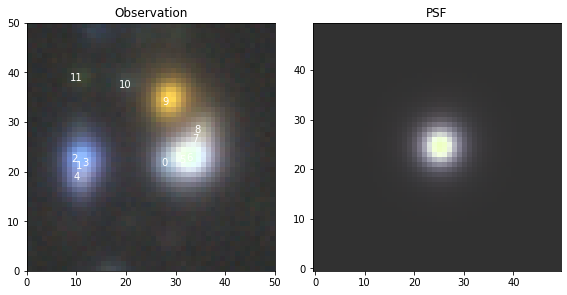

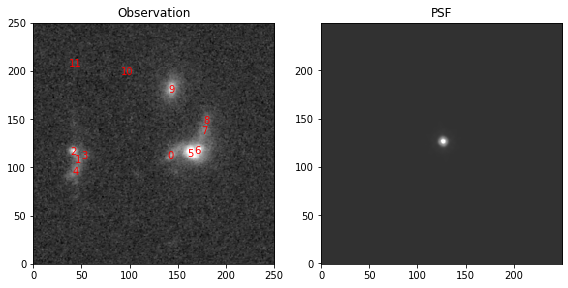

In [5]:
# Create a color mapping for the HSC image
norm_hsc = AsinhMapping(minimum=-1, stretch=5, Q=3)
norm_hst = AsinhMapping(minimum=-1, stretch=5, Q=3)
norms = [norm_hsc, norm_hst]

# Get the source coordinates from the HST catalog
pixel_hst = np.stack((catalog_hst['y'], catalog_hst['x']), axis=1)
# Convert the HST coordinates to the HSC WCS
ra_dec = obs_hst.get_sky_coord(pixel_hst)

for obs, norm in zip(observations, norms):
    scarlet.display.show_observation(obs, norm=norm, sky_coords=ra_dec, show_psf=True)
    plt.show()

## Initialize Sources and Blend

We expect all sources to be galaxies, so we initialized them as `ExtendedSources`.
Afterwards, we match their amplitudes to the data, and create an instance of `Blend` to hold all sources and *all* observations for the fit below.

In [6]:
# Source initialisation
sources = [
    scarlet.ExtendedSource(model_frame, 
                           sky_coord, 
                           observations,
                           thresh=0.1,
                          )
    for sky_coord in ra_dec
]
scarlet.initialization.set_spectra_to_match(sources, observations)
blend = scarlet.Blend(sources, observations)

## Display Initial guess

Let's compare the initial guess in both observation frames. Note that the full model comprises more spectral channels and/or pixels than any individual observation. That's a result of defining 

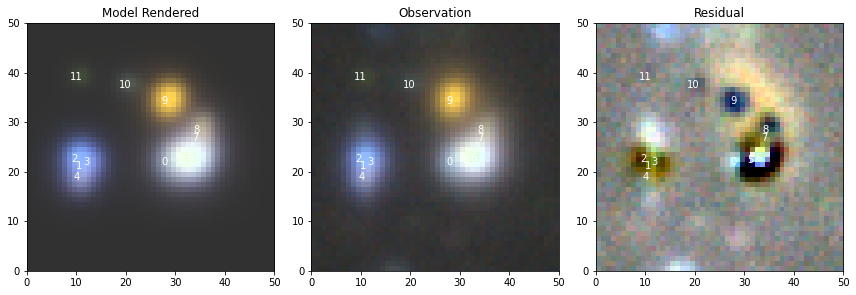

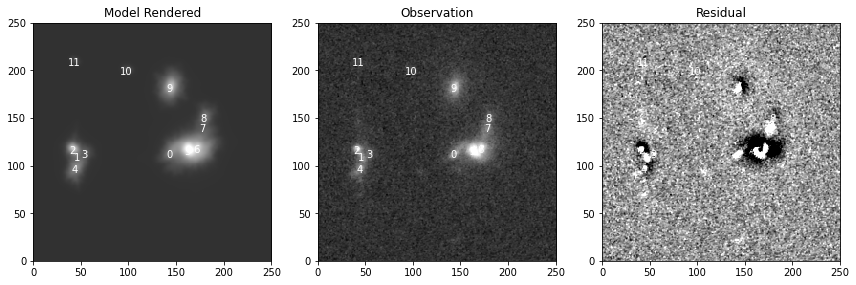

In [7]:
for i in range(len(observations)):
    scarlet.display.show_scene(sources, 
                               norm=norms[i], 
                               observation=observations[i],
                               show_model=False,
                               show_rendered=True, 
                               show_observed=True, 
                               show_residual=True,
                               figsize=(12,4)
                              )
    plt.show()

## Fit Model

CPU times: user 3min 15s, sys: 46.7 s, total: 4min 1s
Wall time: 4min 1s
scarlet ran for 50 iterations to logL = 12029.074284145743


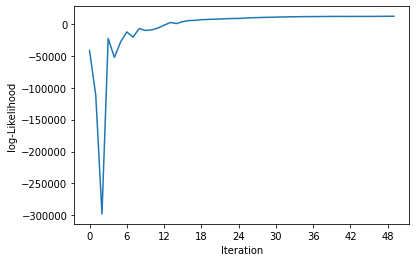

In [8]:
%time it, logL = blend.fit(50, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

### View Updated Model

We use the same principle to look at the updated model:

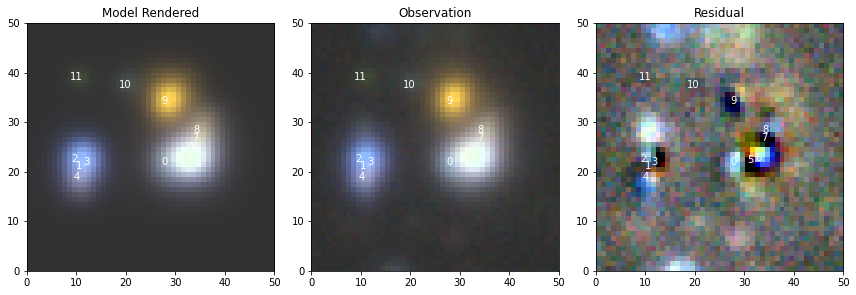

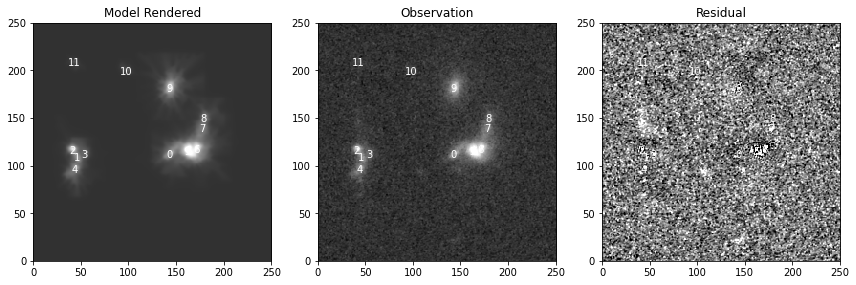

In [9]:
for i in range(len(observations)):
    scarlet.display.show_scene(sources, 
                               norm=norms[i], 
                               observation=observations[i],
                               show_model=False,
                               show_rendered=True, 
                               show_observed=True, 
                               show_residual=True,
                               figsize=(12,4)
                              )
    plt.show()

### View Source Models
It can also be useful to view the model for each source. For each source we extract the portion of the image contained in the sources bounding box, the true simulated source flux, and the model of the source, scaled so that all of the images have roughly the same pixel scale.

source number  0


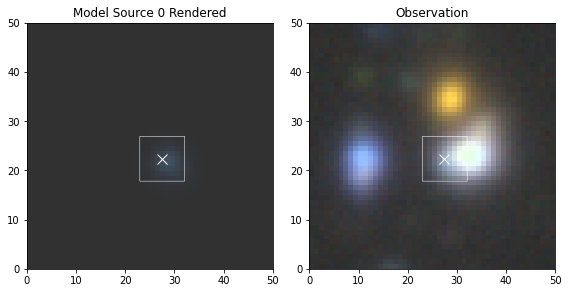

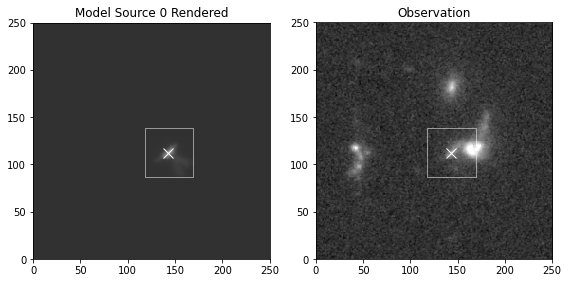

source number  1


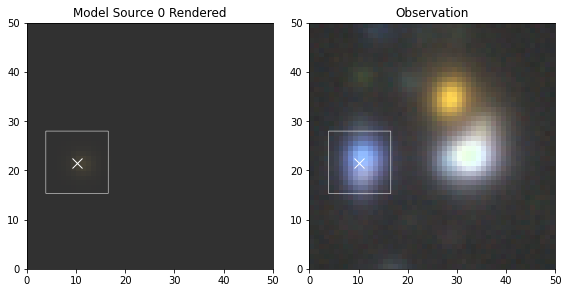

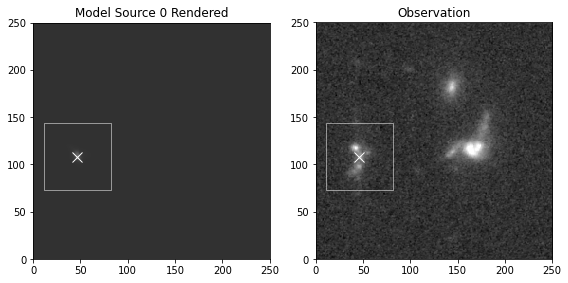

source number  2


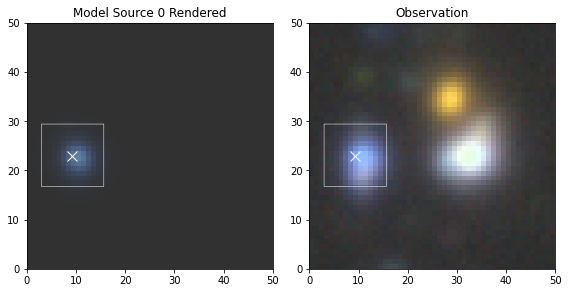

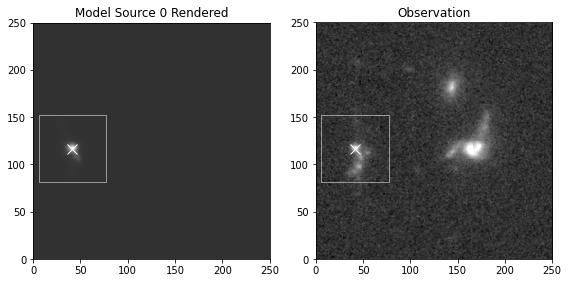

source number  3


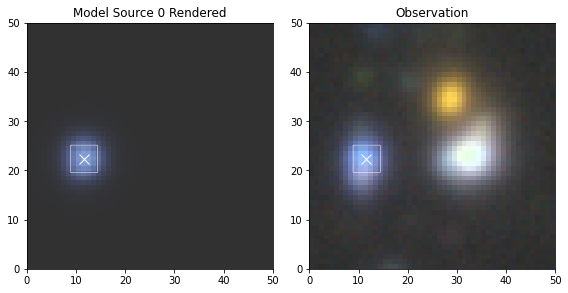

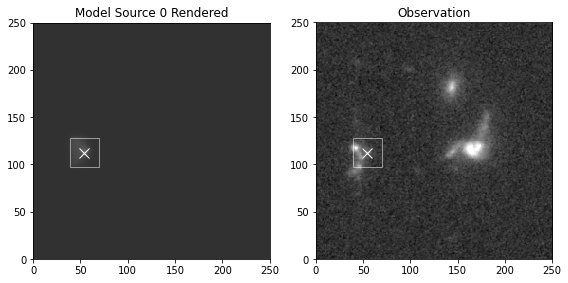

source number  4


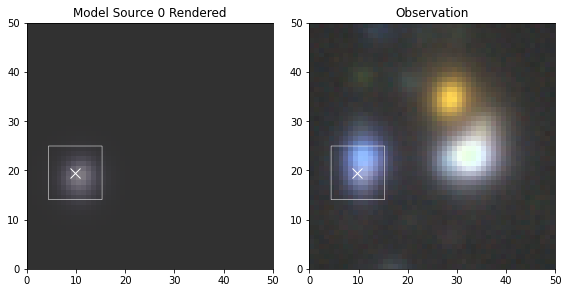

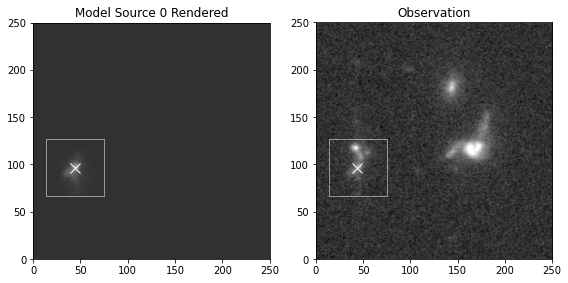

source number  5


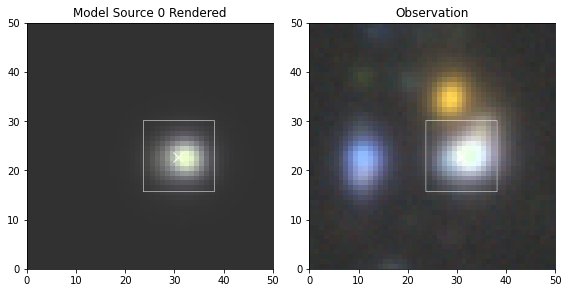

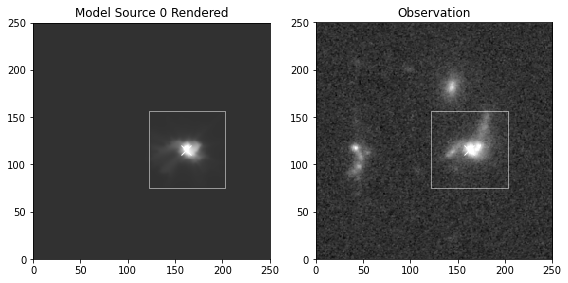

source number  6


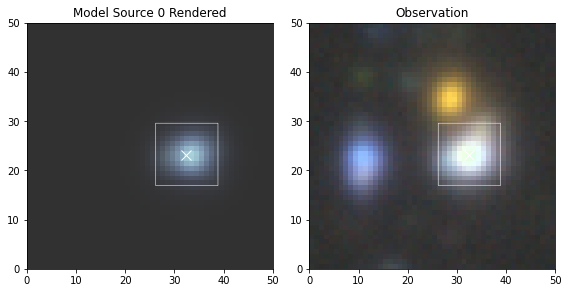

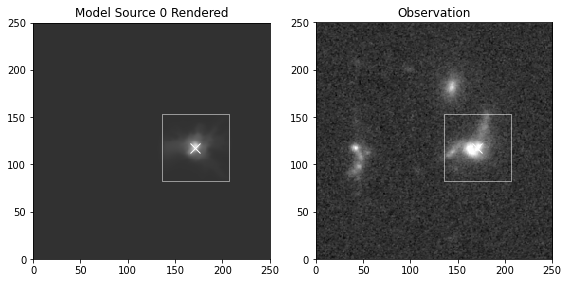

source number  7


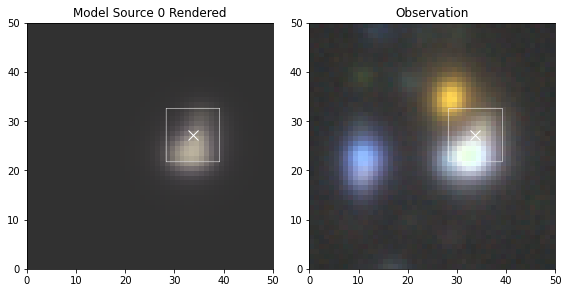

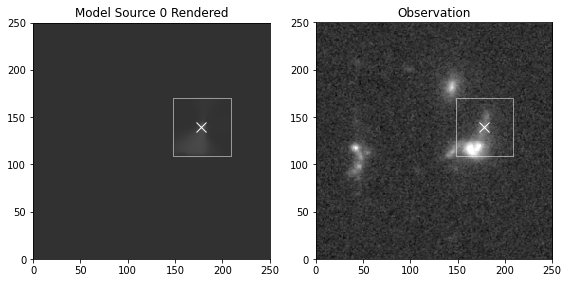

source number  8


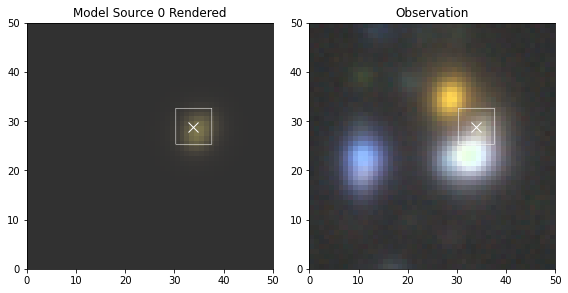

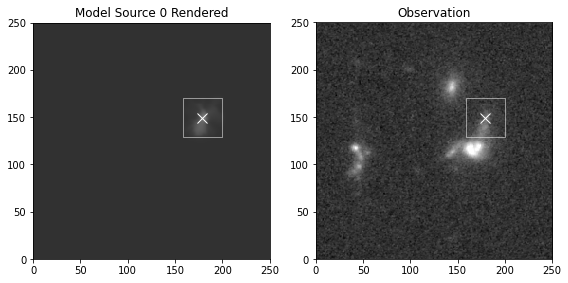

source number  9


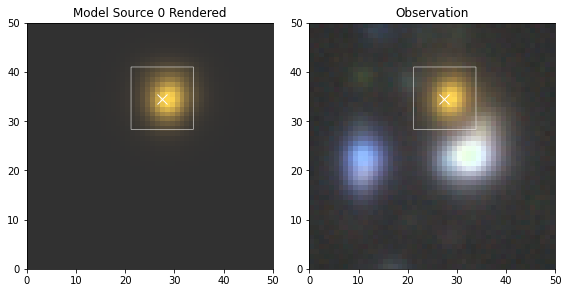

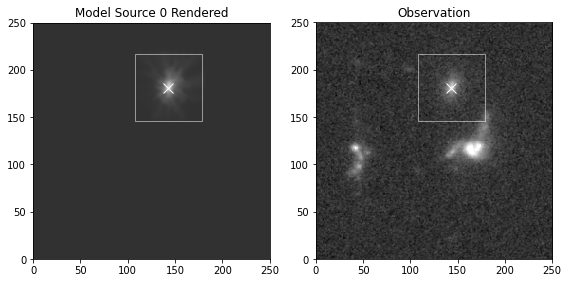

source number  10


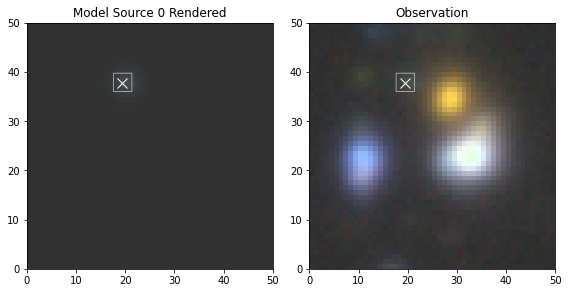

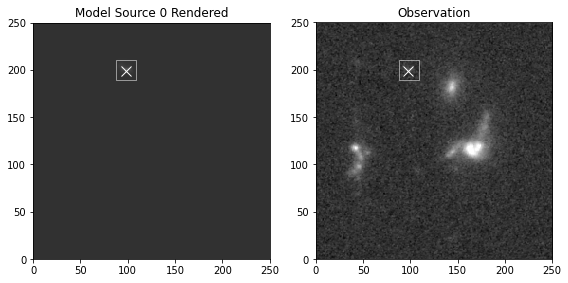

source number  11


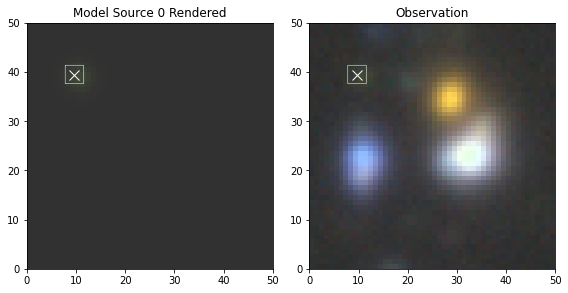

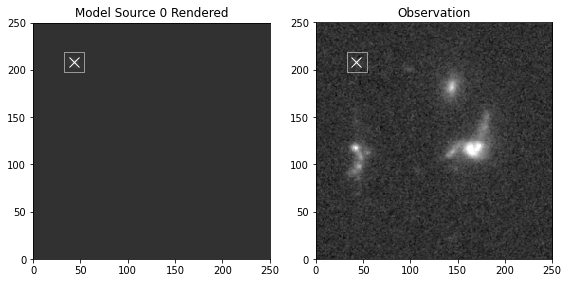

In [10]:
for k in range(len(sources)):
    print('source number ', k)
    for i in range(len(observations)):
        scarlet.display.show_sources((sources[k],), 
                                     norm=norm_hst, 
                                     observation=observations[i],
                                     show_model=False,
                                     show_rendered=True, 
                                     show_observed=True,
                                     show_spectrum=False,
                                     add_boxes=True,
                                     figsize=(8,4)
                                    )
        plt.show()